In [60]:
from prelude import *
import pandas as pd
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType
import re

In [2]:
conf = SparkConf().setAppName("question9").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
tweets_rdd = sc.textFile('../data/English/NoFilterEnglish2020-02-01')
tweets_rdd = tweets_rdd.map(lambda line: json.loads(line))

## Find the top 20 hashtags

In [3]:
# see the 20 most fequent hashtags 

def get_all_hashtags(s):
    hashtags = s['entities']['hashtags']
    res = []
    for hashtag in hashtags:
        res.append((hashtag['text'], 1))
    return res


tweets_rdd.flatMap(get_all_hashtags).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False).take(20)

[('AsimForTheWin', 54334),
 ('AsimRiaz', 4088),
 ('BossBirthdayCDP', 3688),
 ('iHeartAwards', 3150),
 ('ShehnazKaur', 2870),
 ('AsliFans', 2612),
 ('BTS', 2492),
 ('BB13OnVoot', 2331),
 ('BB13', 1806),
 ('BiggBoss13', 1733),
 ('SidharthShukla', 1450),
 ('WONPOCALYPSE', 1368),
 ('Budget2020', 1310),
 ('BestMusicVideo', 1167),
 ('HAPPYDOYOUNGDAY', 1158),
 ('AWKJSJFKSJFLA', 1118),
 ('NCT', 1033),
 ('NCT127', 998),
 ('Brexit', 997),
 ('DOYOUNG', 966)]

## We filter tweets for top 5 hashtags

In [84]:
# top_5_hashtags = ['AsimForTheWin', 'AsimRiaz', 'BossBirthdayCDP', 'iHeartAwards', 'ShehnazKaur']
top_5_hashtags = ['AsimRiaz', 'BossBirthdayCDP', 'iHeartAwards', 'ShehnazKaur', 'BTS']

In [85]:
def filter_hashtag(s, target_hashtag):
    '''
    Filter the tweet who contains target_hashtag
    '''
    hashtags = set(map(lambda h: h['text'], s['entities']['hashtags']))
    return bool(set(target_hashtag).intersection(hashtags))

def tweets_to_hashtag_ind(s, target_hashtag):
    '''
    Map the tweets to a hashtag index
    '''
    hashtags = set(map(lambda h: h['text'], s['entities']['hashtags']))
    return int(np.argmax([int(ht in hashtags) for ht in top_5_hashtags]))
    

In [86]:
# We choose tweets with top 5 hashtags to do the clustering
tweet_with_hashtag = tweets_rdd.filter(lambda s: filter_hashtag(s, top_5_hashtags)).map(lambda s: (s['text'], tweets_to_hashtag_ind(s, top_5_hashtags))).cache()

In [88]:
tweet_with_hashtag.take(2)

[('RT @Tha5SOSVote: 50 REPLIES = 50 VOTES \n\n#iHeartAwards #BestCoverSong #DancingWithAStranger @5SOS https://t.co/C6LB3JhqmN',
  2),
 ("RT @BigHitEnt: #BTS #방탄소년단 #LOVE_YOURSELF 轉 'Tear' Concept Photo O version https://t.co/Zp3uGn4Om9",
  4)]

## Data Preprocessing

In [89]:
def clean_tweet(t: str):
    t = t.replace('\n','').strip()
    t = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",t).split()
    if t[0] == 'RT':
        t = t[1:]
    return t

In [90]:
tweet_with_hashtag_cleaned = tweet_with_hashtag.map(lambda s: (clean_tweet(s[0]), s[1])).cache()

In [91]:
tweet_with_hashtag_cleaned.take(2)

[(['50',
   'REPLIES',
   '50',
   'VOTES',
   'iHeartAwards',
   'BestCoverSong',
   'DancingWithAStranger'],
  2),
 (['BTS', 'LOVE', 'YOURSELF', 'Tear', 'Concept', 'Photo', 'O', 'version'], 4)]

In [92]:
schema = StructType().add(StructField("text", ArrayType(StringType()), True)).add(StructField("label", IntegerType(), True))
tweet_with_hashtag_cleaned_df = spark.createDataFrame(tweet_with_hashtag_cleaned, schema)

In [93]:
tweet_with_hashtag_cleaned_df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|[50, REPLIES, 50,...|    2|
|[BTS, LOVE, YOURS...|    4|
|[Superior, merch,...|    2|
|[UnoI, vote, Kill...|    2|
|[We, are, loosing...|    2|
+--------------------+-----+
only showing top 5 rows



## Training Word Embedding

In [94]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=2, minCount=0, inputCol="text", outputCol="result")

In [96]:
model = word2Vec.fit(tweet_with_hashtag_cleaned_df)

In [56]:
model.getVectors().show(5)

+-----------+--------------------+
|       word|              vector|
+-----------+--------------------+
|      gawar|[0.22480939328670...|
|     Talent|[-0.0805391818284...|
|NallaSalman|[-0.1041146069765...|
|         CV|[-0.2451101094484...|
|   incident|[-0.1785762459039...|
+-----------+--------------------+
only showing top 5 rows



In [97]:
result = model.transform(tweet_with_hashtag_cleaned_df)

In [59]:
result.show(5)

+--------------------+-----+--------------------+
|                text|label|              result|
+--------------------+-----+--------------------+
|[50, REPLIES, 50,...|    3|[0.62918047394071...|
|[Superior, merch,...|    3|[0.56641740798950...|
|[UnoI, vote, Kill...|    3|[0.28739034032656...|
|[We, are, loosing...|    3|[0.25208640622440...|
|[If, you, care, y...|    3|[0.56697330375512...|
+--------------------+-----+--------------------+
only showing top 5 rows



## K-means Clustering

In [61]:
from pyspark.ml.clustering import KMeans

In [98]:
kmeans = KMeans().setK(5).setSeed(1234).setFeaturesCol('result')
model = kmeans.fit(result.select('label', 'result'))
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.40358314 0.45638839]
[ 0.09737092 -0.62920729]
[-0.72012852  1.26349304]
[-0.07919385  0.20829124]
[-1.61116483 -0.55217177]


In [99]:
transformed = model.transform(result.select('label', 'result'))

In [65]:
transformed.show(2)

+-----+--------------------+----------+
|label|              result|prediction|
+-----+--------------------+----------+
|    3|[0.62918047394071...|         4|
|    3|[0.56641740798950...|         1|
+-----+--------------------+----------+
only showing top 2 rows



In [100]:
pddf_pred = transformed.toPandas()

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

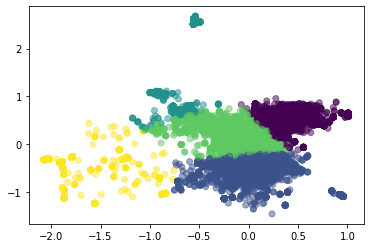

In [102]:
x = pddf_pred.result.apply(lambda x: x[0])
y = pddf_pred.result.apply(lambda x: x[1])
plt.scatter(x, y, c=pddf_pred.prediction, alpha=0.5)
plt.savefig('kmeans-new-predict.png')

## Ground Truth

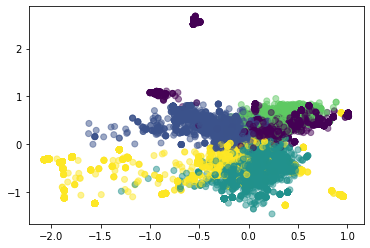

In [103]:
plt.scatter(x, y, c=pddf_pred.label, alpha=0.5)
plt.savefig('new-ground-truth.png')

## Gaussian Mixture Model

In [104]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(5).setSeed(538009335).setFeaturesCol('result')
model = gmm.fit(result.select('label', 'result'))

In [105]:
transformed = model.transform(result.select('label', 'result'))

In [106]:
pddf_pred = transformed.toPandas()

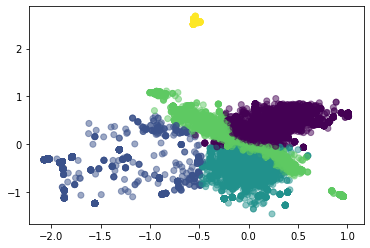

In [107]:
x = pddf_pred.result.apply(lambda x: x[0])
y = pddf_pred.result.apply(lambda x: x[1])
plt.scatter(x, y, c=pddf_pred.prediction, alpha=0.5)
plt.savefig('GMM-new-predict.png')